#Machine Learning Tutorial


The naive Bayes multiclass approach is an extension of the naive Bayes approach. It can be trained to output binary images given an input color image. Unlike the naive Bayes method, the naive Bayes multiclass approach can be trained to classify two or more classes, defined by the user. Additionally, the naive Bayes multiclass method is trained using colors sparsely sampled from images rather than the need to label all pixels in a given image.

To train the classifier, we need to build a table of red, green, and blue color values for pixels sampled evenly from each class. The idea here is to collect a relevant sample of pixel color data for each class. The size of the sample needed to build robust probability density functions for each class will depend on a number of factors, including the variability in class colors and imaging quality/reproducibility. 

To collect pixel color data we currently use the Pixel Inspection Tool in ImageJ. 
Use the Pixel Inspector Tool to select regions of the image belonging to a single class. Clicking on a pixel in the image will give you a set of R,G,B values for a window of pixels around the central pixel. In this example, nine pixels are sampled with one click but the radius is adjustable in "Prefs".

Each column in the tab-delimited table is a feature class (in this example, plant, pustule, chlorosis, or background) and each cell is a comma-separated red, green, and blue triplet for a pixel.

From the "Pixel Values" window you can copy the values and paste them into a text editor such as Notepad on Windows, TextEditor on MacOS, Atom or VS Code. The R,G,B values for a class should be proceeded with a line that contains the class name preceded by a #. The file contents should look like this:

#plant 93,166,104 94,150,101 82,137,91 86,154,102 87,145,94 79,137,95 116,185,135 103,172,126 96,166,126 #postule 216,130,52 217,129,51 221,132,53 218,131,53 223,132,54 221,132,53 219,131,54 221,132,54 225,135,56 #chlorosis 255,242,89 255,241,90 255,239,87 254,239,87 255,241,90 254,238,88 255,241,88 253,238,87 255,240,90 #background 31,42,54 42,52,60 40,49,58 28,38,51 32,43,55 36,47,59 24,35,45 30,40,50 37,49,66

Next, each class needs to be in its own column for the plantcv-train. You can use a utility script provided with PlantCV in plantcv-utils.py that will convert the data from the Pixel Inspector to a table for the bayes training algorithm.

python plantcv-utils.py tabulate_bayes_classes -i pixel_inspector_rgb_values.txt -o bayes_classes.tsv

A note if you are using Windows you will need to specify the whole path to plantcv-utils.py. For example with an Anaconda installation it would be python %CONDA_PREFIX%/Scripts/plantcv-utils.py tabulate_bayes_classes -i pixel_inspector_rgb_values.txt -o bayes_classes.tsv
where pixel_inspector_rgb_values.txt is the file with the pixel values you created above and bayes_classes.tsv is the file with the table for plantcv-train.py.
An example table built from pixel samples for use in plantcv-train.py looks like this:

plant postule chlorosis background 93,166,104 216,130,52 255,242,89 31,42,54 94,150,101 217,129,51 255,241,90 42,52,60 82,137,91 221,132,53 255,239,87 40,49,58 86,154,102 218,131,53 254,239,87 28,38,51 87,145,94 223,132,54 255,241,90 32,43,55 79,137,95 221,132,53 254,238,88 36,47,59 116,185,135 219,131,54 255,241,88 24,35,45 103,172,126 221,132,54 253,238,87 30,40,50 96,166,126 225,135,56 255,240,90 37,49,66






Once a satisfactory sample of pixels is collected, save the table as a tab-delimited text file. Use plantcv-train.py to use the pixel samples to output probability density functions (PDFs) for each class.

plantcv-train.py naive_bayes_multiclass --file pixel_samples.txt --outfile naive_bayes_pdfs.txt --plots

The output file from plantcv-train.py will contain one row for each color channel (hue, saturation, and value) for each class. The first and second column are the class and channel label, respectively. The remaining 256 columns contain the p-value from the PDFs for each intensity value observable in an 8-bit image (0-255).

Once we have the plantcv-train.py output file, we can classify pixels in a color image in PlantCV. In the example image for this tutorial we have already collected pixels and created the probability density functions for each class.

plantcv-train.py naive_bayes_multiclass --file pixel_samples.txt --outfile naive_bayes_pdfs.txt --plots

In [1]:
# Import libraries

import cv2
import numpy as np
from plantcv import plantcv as pcv
import pandas as pd

#Librería para contar número de objetos (Cálculo del número de Euler)
import mahotas

# Set global debug behavior to None (default), "print" (to file), 
# or "plot" (Jupyter Notebooks or X11)
pcv.params.debug = "print"


image="./viola00.jpg"
pdfs="./resulted-multiclass-pdfs.txt"
results="./resulted-multiclas.json"



In [2]:
class options:
    def __init__(self):
        self.image = image
        self.debug = "plot"
        self.writeimg= False 
        self.result = results
        self.outdir = "."

# Get options
args = options()

# Set debug to the global parameter 
pcv.params.debug = args.debug

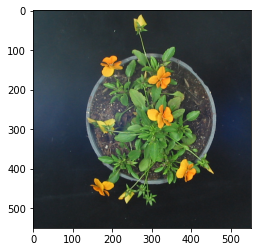

In [3]:
# Read in a color image 

# Inputs:
#   filename - Image file to be read in 
#   mode - Return mode of image; either 'native' (default), 'rgb', 'gray', or 'csv' 
img, path, filename = pcv.readimage(filename=args.image)
# Read in a color image
#img, path, filename = pcv.readimage("color_image.png")



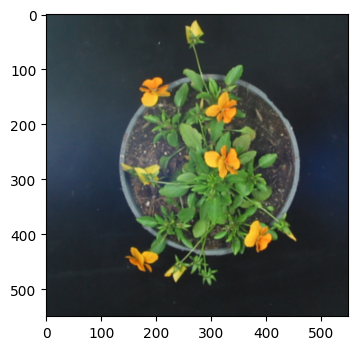

In [4]:
gaussian_img = pcv.gaussian_blur(img=img, ksize=(5, 5), sigma_x=1, sigma_y=1)

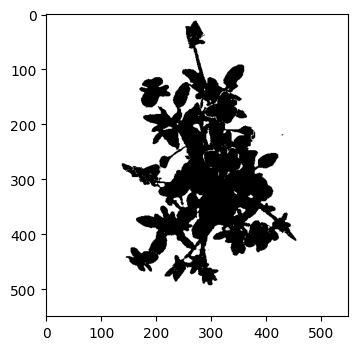

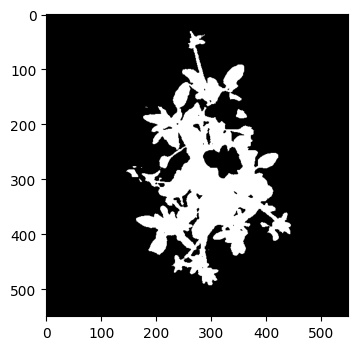

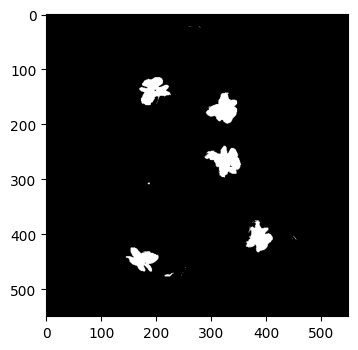

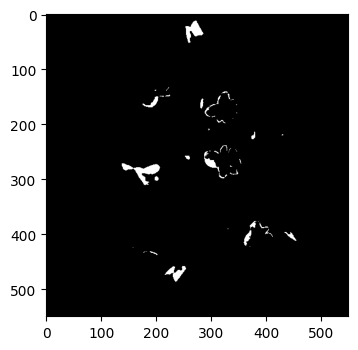

In [5]:
# Use the output file from `plantcv-train.py` to run the multiclass 
# naive bayes classification on the image. The function below will 
# print out 4 masks (lesson,prelesson, green, background)

# Inputs: 
#   rgb_img - RGB image data 
#   pdf_file - Output file containing PDFs from `plantcv-train.py`
mask = pcv.naive_bayes_classifier(rgb_img=gaussian_img, 
                                  pdf_file=pdfs)



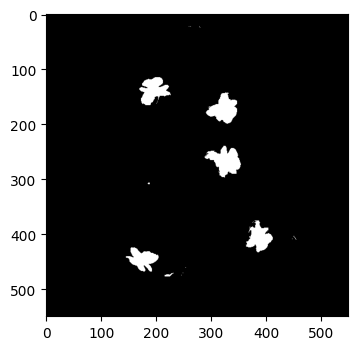

In [6]:
flor_img=pcv.fill_holes(bin_img=mask['flor'])

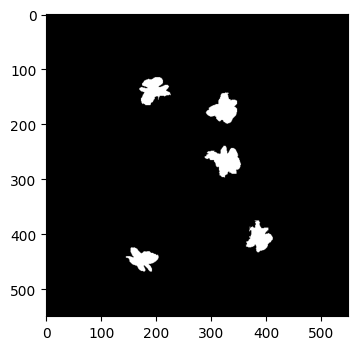

In [7]:
flor_fill=pcv.fill(bin_img=flor_img, size=200)

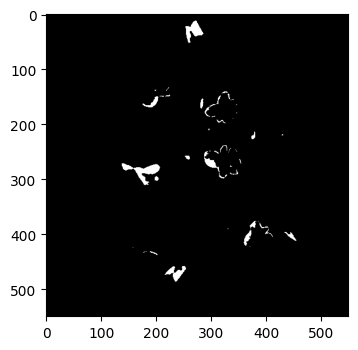

In [8]:
flor_senescente_img=pcv.fill_holes(bin_img=mask['florsenscente'])

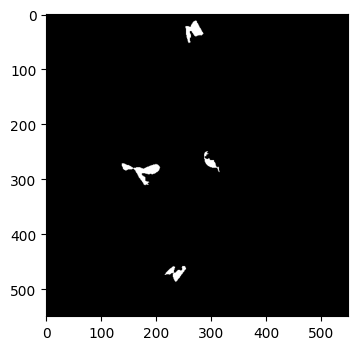

In [9]:
flor_senescente_fill=pcv.fill(bin_img=flor_senescente_img, size=200)

In [10]:
mask['flor']=flor_fill
mask['florsenscente']=flor_senescente_fill

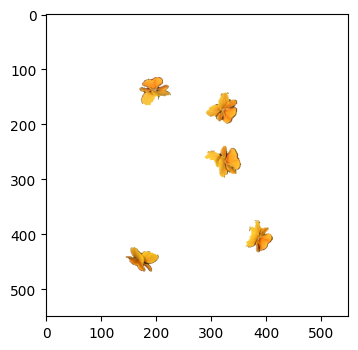

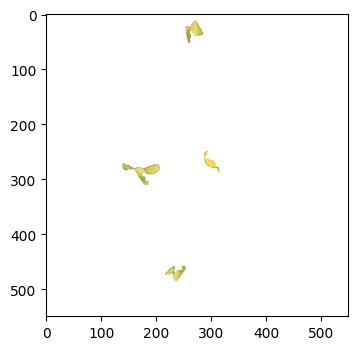

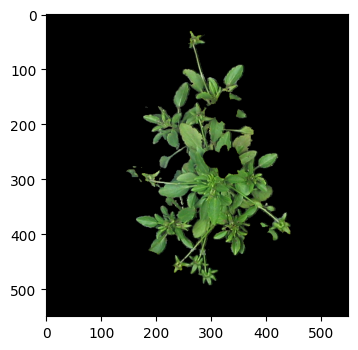

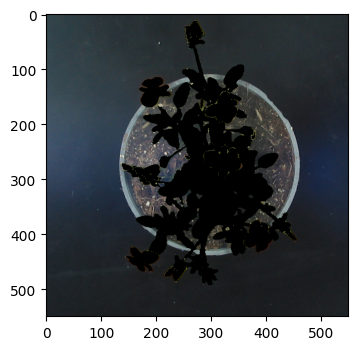

In [11]:
# We can apply each mask to the original image to more accurately 
# see what got masked

# Inputs:
#   img - RGB or grayscale image data 
#   mask - Binary mask image data 
#   mask_color - 'white' or 'black' 
flor_img = pcv.apply_mask(mask=(mask['flor']), img=img, mask_color='white')
florsenescente_img = pcv.apply_mask(mask=(mask['florsenscente']), img=img, mask_color='white')
planta_img = pcv.apply_mask(mask=(mask['planta']), img=img, mask_color='black')
background_img = pcv.apply_mask(mask=(mask['fondo']), img=img, mask_color='black')



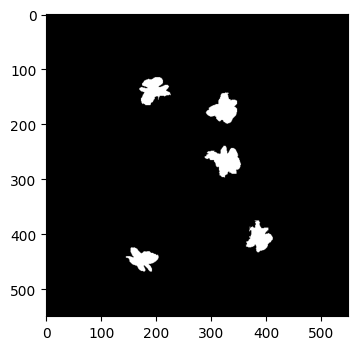

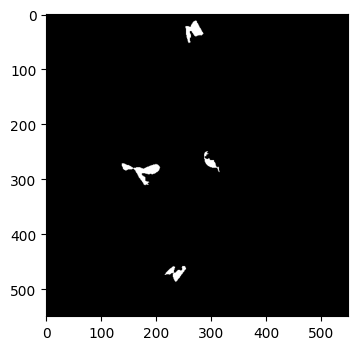

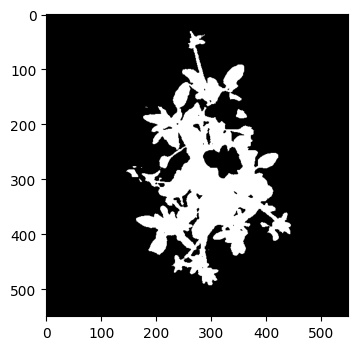

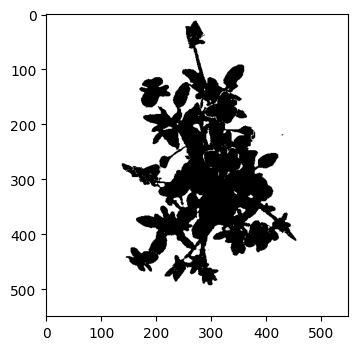

In [12]:
# Write image and mask with the same name to the path 
# specified (creates two folders within the path if they do not exist).

# Inputs: 
#   img - RGB or grayscale image data, original image 
#   mask - Binary mask image created 
#   filename - Image filename to get saved as
#   outdir - Output directory (default: None)
#   mask_only - Defaults to False, if True then only outputs mask 
lesson_maskpath, plant_analysis_images = pcv.output_mask(img=img, mask=mask['flor'], 
                                                        filename='flor.png', mask_only=True)
predamage_maskpath, pust_analysis_images = pcv.output_mask(img=img, mask=mask['florsenscente'], 
                                                      filename='florsenscente.png', mask_only=True)
green_maskpath, chlor_analysis_images = pcv.output_mask(img=img, mask=mask['planta'], 
                                                        filename='planta.png', mask_only=True)
bkgrd_maskpath, bkgrd_analysis_images = pcv.output_mask(img=img, mask=mask['fondo'], 
                                                        filename='fondo.png', mask_only=True)



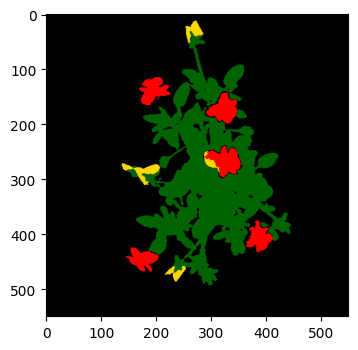

In [13]:
# To see all of these masks together we can plot them with plant set to green,
# chlorosis set to gold, and pustule set to red.

# Inputs:
#   masks - List of masks (the different classes returned by naive_bayes_classifier)
#   colors - List of colors to assign to each class. Users can either provide a 
#   list of color names (str) or can provide tuples of custom BGR values
classified_img = pcv.visualize.colorize_masks(masks=[mask['flor'], mask['florsenscente'], 
                                                     mask['planta'], mask['fondo']], 
                                              colors=['red','gold', 'dark green', 'black'])



In [14]:


# Calculate percent of the plant found to be diseased 
planta_total = np.count_nonzero(mask['planta']) + np.count_nonzero(mask['flor']) + np.count_nonzero(mask['florsenscente'])
flor = np.count_nonzero(mask['flor'])
flor_senescente= np.count_nonzero(mask['florsenscente'])
                                  
porciento_flor = flor*100 / (flor + planta_total+flor_senescente)
porciento_flor_senescente = flor_senescente*100 / (flor + planta_total+flor_senescente)                                  
porciento_planta = planta_total*100 / (img.shape[0]*img.shape[1])

print('Superficie de flor (%):','{:.1f}'.format(porciento_flor))
print('Superficie de flor senescente (%):','{:.1f}'.format(porciento_flor_senescente))
print('Superficie de la planta en la imagen (%):', '{:,.1f}'.format(porciento_planta))

Superficie de flor (%): 12.6
Superficie de flor senescente (%): 3.4
Superficie de la planta en la imagen (%): 18.8


In [15]:
#Se convierte los datos de la imagen en boolean (blanco =True, negro = False)

arraybool=np.array(flor_fill, dtype=bool)

#Convert binary array into an image
#imageres=Image.fromarray(imgdilation, mode='L')
#print(black_white)
#print image i gray scale (black and white)
#imres=plt.imshow(imageres,cmap='gray', vmin=0, vmax=255)

#El número de Euler (número entero) calcula el número de objetos menos el número de
#agujeros en los objetos.
#Se usa la función euler de la librería mahotas

#parámetros:
    #-imagen binaria de dos dimensiones
    #- Entero, conectividad. Opciones: 4 u 8. Default: 8
    #-mode: {‘reflect’, ‘nearest’, ‘wrap’, ‘mirror’, ‘constant’ [default]}
    
nflores=mahotas.euler(arraybool,8)
print('Número de flores', nflores)

Número de flores 5.0


In [16]:
# Create a new measurement (gets saved to the outputs class) 

# Inputs:
#    sample - A sample name or label
#    variable - The name of the variable for the observation to get stored. Must be unique to other variable names
#               since data is a dictionary format where variable is the key.
#    trait - Description of the observation getting stored
#    method - Description of the method for calculating the observation
#    scale - Observation scale
#    datatype - The datatype of the observation, most commonly either bool, str, int, float, list 
#    value - Value of the observation getting stored
#    label - Label for the observation getting stored. Required for list datatype observations. 
pcv.outputs.clear()

#pcv.outputs.add_observation(sample='default', variable='percent_diseased', trait='percent of plant detected to be diseased',
#                            method='ratio of pixels', scale='percent', datatype=float,
#                            value=percent_diseased, label='percent')

pcv.outputs.add_observation(variable='porciento_flor', trait='porciento de superficie de flor',
                            method='relación de píxeles', scale='porciento', datatype=float,
                            value=porciento_flor, label='porciento_flor')





TypeError: add_observation() missing 1 required positional argument: 'sample'

In [ ]:
# Data stored to the outputs class can be accessed using the variable name
#pcv.outputs.observations['default']['percent_diseased']['value']
pcv.outputs.observations['porciento_flor']['value']




In [17]:
# The print_results function will take the measurements stored when running any (or all) of these functions, format, 
# and print an output text file for data analysis. The Outputs class stores data whenever any of the following functions
# are ran: analyze_bound_horizontal, analyze_bound_vertical, analyze_color, analyze_nir_intensity, analyze_object, 
# fluor_fvfm, report_size_marker_area, watershed. If no functions have been run, it will print an empty text file 
pcv.print_results(filename=args.result)

Deprecation warning: plantcv.print_results will be removed in a future version.
             Please use plantcv.outputs.save_results instead.
          


To view and/or download the text file output (saved in JSON format)...
1) To see the text file with data that got saved out, click “File” tab in top left corner. 2) Click “Open…” 3) CLick on the file named “ml_tutorial_results.txt”
Check out documentation on how to convert JSON format output into table formatted output. Depending on the analysis steps a PlantCV user may have two CSV files (single value traits and multivalue traits).

In [18]:
    #Se usa la función 'read_json' para leer el archivo json y guardarlo como csv
    #De esta forma se puede abrir en excel
df = pd.read_json (r'./' + args.result)
df.to_csv (r'./' + 'resulted-multiclass' +  '.csv', index = None,header=True)

    #Con este procedimiento se convierte un archivo 'json' en archivo 'csv'
    #En excel, en la pestaña de datos, seleccionar obtener datos externos, y seleccionar
    #la opción desde texto. Ahi seleccionar el archivo *.csv para importar a excel. Seleccionar
    # la opción delimitados, siguiente, y seleccionar la opción delimitadores: coma
    # y seleccionar finalizar.

    #Después seleccionar las celdas con el texto, y en la pestaña datos, seleccionar
    # texto en columnas, seleccionar delimitados, seleccionar delimitadores 'coma' y 
    # y en 'otro' escribir ':'. Después seleccionar siguiente, y finalizar.

